# Polygenic score (PGS) analysis 

This notebook calculates polygenic scores (PGS) using genotype data from VCF files generated from the ag-vampir amplicon sequencing panel. The workflow includes reading and processing VCF files, filtering SNPs based on missingness and minor allele frequency (MAF), performing association tests using generalized linear models (GLMs), and calculating polygenic scores for individual samples. Additionally, the notebook includes functions for pruning SNPs in linkage disequilibrium (LD) and visualizing the results. The analysis is tailored for a specific dataset from Siaya, but the functions are modular and can be adapted for other datasets. The goal is to identify genetic variants associated with a phenotype of interest and compute a polygenic score for insecticide resistance.

In [1]:
import pandas as pd
import numpy as np
import allel
import plotly.express as px

def vcf_to_siaya_glm_data(vcf_path, df_samples, max_missing_filter=0.20, min_maf_filter=0.02 ,split_multiallelic=True, convert_genotypes=True):
    """
    Process a VCF file and prepare genotype data for GLM analysis.

    Parameters:
    vcf_path : str
        Path to the VCF file.
    df_samples : pd.DataFrame
        DataFrame containing sample metadata, including sample IDs and locations.
    max_missing_filter : float, optional
        Maximum allowed proportion of missing genotypes per SNP (default is 0.20).
    min_maf_filter : float, optional
        Minimum minor allele frequency (MAF) threshold for filtering SNPs (default is 0.02).
    split_multiallelic : bool, optional
        Whether to split multiallelic SNPs into separate rows (default is True).
    convert_genotypes : bool, optional
        Whether to convert genotypes to alternate allele counts (0, 1, 2) (default is True).

    Returns:
    pd.DataFrame
        A DataFrame containing processed genotype data, with SNPs as columns and samples as rows.
    """
    # Read VCF and create a dictionary
    vcf_df = vcf_to_siaya_df(vcf_path, df_samples, max_missing_filter=max_missing_filter, min_maf_filter=min_maf_filter)
    samples = vcf_df.columns[6:]

    if split_multiallelic:
        vcf_df = split_rows_with_multiple_alleles(vcf_df, samples)

    # Convert genotypes to 0/1/2
    if convert_genotypes:
        vcf_df = convert_genotype_to_alt_allele_count(vcf_df, samples)

    vcf_df = vcf_df.assign(
        snp_id=lambda x: "snp_" + x.CHROM.astype(str) + ":" + x.POS.astype(str) + "_" + x.REF.astype(str) + ">" + x.ALT.astype(str)
    )
    vcf_df = vcf_df.set_index('snp_id')
    vcf_df = vcf_df.drop(columns=['CHROM', 'POS', 'FILTER_PASS', 'REF', 'ALT', 'ANN']).T
    vcf_df = pd.concat([df_samples.set_index('sample_id').query('location == "Siaya"'), vcf_df], axis=1)
    
    return vcf_df
    

def vcf_to_siaya_df(vcf_path, df_samples, max_missing_filter=0.20, min_maf_filter=0.02, query=None):
    # Read VCF file
    vcf_dict = allel.read_vcf(vcf_path, fields='*')
    samples = vcf_dict['samples']
    contig = vcf_dict['variants/CHROM'] 
    pos = vcf_dict['variants/POS']
    filter_pass = vcf_dict['variants/FILTER_PASS']
    ref = vcf_dict['variants/REF']
    alt = np.apply_along_axis(lambda x: ','.join(x[x != '']), 1, vcf_dict['variants/ALT'])
    ann = vcf_dict['variants/ANN']
    geno = allel.GenotypeArray(vcf_dict['calldata/GT'])
    
    print(f"Initial number of samples: {len(samples)}")
    print(f"Initial number of SNPs: {geno.shape[0]}")
    
    # filter to Siaya data
    siaya_mask = df_samples.eval("sample_id.str.contains('Siaya')", engine='python')
    sample_mask = np.isin(samples, df_samples[siaya_mask].sample_id)

    geno = geno.compress(sample_mask, axis=1)
    samples = samples[sample_mask]

    if query is not None:
        mask = df_samples.eval(query, engine='python')
        geno = geno.compress(mask, axis=1)
        samples = samples[mask]
    
    print(f"Final number of samples: {len(samples)}")
        
    # Calculate allele counts and apply filters
    ac = geno.count_alleles(max_allele=3)
    seg_mask = ac.is_segregating()
    miss_mask = (geno.is_missing().sum(axis=1) <= int(geno.shape[1]*max_missing_filter))
    maf_mask = ac.to_frequencies()[:, 1:].sum(axis=1) > min_maf_filter
    
    print(f"invariant SNPs removed: {np.sum(~seg_mask)}")
    print(f"SNPs removed due to high missingness (>{max_missing_filter*100}%): {np.sum(~miss_mask)}")
    print(f"SNPs removed due to low MAF (<{min_maf_filter}): {np.sum(~maf_mask)}")
    
    # Apply all filters
    mask = np.logical_and(seg_mask, np.logical_and(miss_mask, maf_mask))
    
    # Compress data based on mask
    geno = geno.compress(mask, axis=0)
    contig = contig[mask]
    pos = pos[mask]
    filter_pass = filter_pass[mask]
    ref = ref[mask]
    alt = alt[mask]
    ann = ann[mask]
    
    print(f"Final number of SNPs after all filters: {geno.shape[0]}")
    
    # Create DataFrame versions of VCF and genotypes
    vcf_df = pd.DataFrame({'CHROM': contig, 'POS': pos, 'FILTER_PASS': filter_pass, 'REF': ref, 'ALT': alt, 'ANN': ann})
    geno_df = pd.DataFrame(geno.to_gt().astype(str), columns=samples)
    
    # Combine VCF and genotype DataFrames
    vcf = pd.concat([vcf_df, geno_df], axis=1)
    
    print(f"Final DataFrame shape: {vcf.shape}")
    
    return vcf

def split_rows_with_multiple_alleles(df, samples):
    # Create an empty list to store the new rows
    new_rows = []
    # Iterate through each row
    for index, row in df.iterrows():
        alt_alleles = row['ALT'].split(',')
        # Check if there are multiple alleles in the ALT field
        if len(alt_alleles) > 1:
            for allele_num, allele in enumerate(alt_alleles):
                # Create a new row for each allele
                new_row = row.copy()
                new_row['ALT'] = allele
                # Update genotype fields
                for col in samples:
                    genotype = row[col]
                    # Split the genotype and process it
                    if genotype != './.':
                        gt_alleles = genotype.split('/')
                        new_gt = ['0' if (int(gt) != allele_num + 1 and gt != '0') else gt for gt in gt_alleles]
                        new_row[col] = '/'.join(new_gt)
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    
    new_df = pd.DataFrame(new_rows).reset_index(drop=True)
    return new_df


def convert_genotype_to_alt_allele_count(df, samples):
    """
    Convert genotype data to alternate allele counts (0, 1, or 2).

    Parameters:
    df : pd.DataFrame
        DataFrame containing genotype data, with genotypes in the format '0/0', '0/1', etc.
    samples : list
        List of sample IDs corresponding to genotype columns in the DataFrame.

    Returns:
    pd.DataFrame
        A DataFrame with genotypes converted to alternate allele counts.
    """
    nalt_df = df.copy()
    # Iterate through each row
    for index, row in df.iterrows():
        # Update genotype fields
        for col in samples:
                genotype = row[col]
                if genotype != './.':
                    # Split the genotype and count non-zero alleles
                    alleles = genotype.split('/')
                    alt_allele_count = sum([1 for allele in alleles if allele != '0'])
                    nalt_df.at[index, col] = alt_allele_count
                else:
                    nalt_df.at[index, col] = np.nan

    return nalt_df

#### Code -  run GLM and process results

In [2]:
def calculate_pseudo_r2(results):
    """
    Calculate different pseudo R² measures for a fitted GLM model
    
    Parameters:
    results : statsmodels GLMResults object
        The fitted model results
        
    Returns:
    dict : Dictionary containing different pseudo R² measures
    """
    ll_null = results.null_deviance / -2
    ll_model = results.deviance / -2
    n = results.nobs
    
    r2_mcfadden = 1 - (ll_model / ll_null)
    r2_coxsnell = 1 - np.exp((2/n) * (ll_null - ll_model))
    r2_nagelkerke = r2_coxsnell / (1 - np.exp((2/n) * ll_null))
    
    return {
        'McFadden R²': r2_mcfadden,
        'Nagelkerke R²': r2_nagelkerke
    }

def glm_all_snps(snp_df):
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    from statsmodels.stats.multitest import fdrcorrection
    
    dfs = []
    for snp in snp_df.filter(like="snp_").columns:
        glm_data = snp_df[['phenotype', snp]].dropna()
        glm_data[snp] = glm_data[snp].astype(int)
        glm_data.columns = ['phenotype', 'snp']
    
        df_contingency = pd.crosstab(glm_data['phenotype'], glm_data['snp'])
        
        formula = f'phenotype ~ snp'
        logit_model = smf.glm(formula=formula, data=glm_data, family=sm.families.Binomial())
        log_results = logit_model.fit()
        
        # Calculate pseudo R² measures
        r2_values = calculate_pseudo_r2(log_results)
    
        pval_data = results_summary_to_dataframe(log_results)
        # Add R² values to the results
        for r2_name, r2_value in r2_values.items():
            pval_data[r2_name] = r2_value
            
        dfs.append(pval_data.assign(snp=snp))
        
    df_eff = pd.concat(dfs).query("index != 'Intercept'")
    res = fdrcorrection(df_eff['pvals'], alpha=0.05)
    df_eff['fdr'] = res[1]
    df_eff['fdr_sig'] = res[0]
    return process_effect_sizes(df_eff)


def process_effect_sizes(df_eff):
    assert 'snp' in df_eff.columns, "Expected 'snp' column in effect size dataframe."
    assert df_eff['snp'].is_unique, "Expected one GLM result per SNP; found duplicate SNP IDs before annotation merge."

    parsed = df_eff['snp'].str.extract(r"^snp_(?P<CHROM>[^:]+):(?P<POS>\d+)_(?P<REF>[^>]+)>(?P<ALT>.+)$")
    assert parsed.notna().all().all(), (
        "Unable to parse one or more SNP IDs. Expected format: snp_<CHROM>:<POS>_<REF>><ALT>."
    )

    df_eff = pd.concat([df_eff, parsed], axis=1)
    df_eff['POS'] = df_eff['POS'].astype(int)

    required_ann_cols = {'CHROM', 'POS', 'REF', 'ALT', 'ANN'}
    missing_ann_cols = required_ann_cols.difference(snp_data.columns)
    assert not missing_ann_cols, f"snp_data is missing required columns: {sorted(missing_ann_cols)}"

    ann_df = snp_data[list(required_ann_cols)].copy()
    ann_df = ann_df.assign(
        snp=lambda x: "snp_" + x.CHROM.astype(str) + ":" + x.POS.astype(int).astype(str) + "_" + x.REF.astype(str) + ">" + x.ALT.astype(str)
    )

    duplicate_ann = ann_df['snp'].duplicated(keep=False)
    assert not duplicate_ann.any(), (
        "Annotation table contains duplicate SNP IDs even after using CHROM+POS+REF+ALT. "
        f"Example duplicates: {ann_df.loc[duplicate_ann, 'snp'].head(5).tolist()}"
    )

    pre_merge_rows = len(df_eff)
    df_eff = df_eff.merge(
        ann_df[['snp', 'ANN']],
        on='snp',
        how='left',
        validate='one_to_one'
    )
    assert len(df_eff) == pre_merge_rows, "Annotation merge changed row count unexpectedly."

    missing_ann = df_eff['ANN'].isna()
    assert not missing_ann.any(), (
        "Missing annotation for one or more SNPs after merge. "
        f"Example SNPs: {df_eff.loc[missing_ann, 'snp'].head(5).tolist()}"
    )

    cols = ['snp'] + [col for col in df_eff.columns if col != 'snp']
    df_eff = df_eff[cols].drop(columns=['CHROM', 'POS', 'REF', 'ALT'])
    df_eff = df_eff.set_index('snp')
    assert df_eff.index.is_unique, "Effect size index must be unique before LD pruning."
    return df_eff


def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "odds_ratio":np.exp(coeff),
                               "conf_lower":np.exp(conf_lower),
                               "conf_higher":np.exp(conf_higher)
                                })
    
    results_df.loc[:, 'sig'] = [True if pval <= 0.05 else False for pval in pvals]
    results_df = results_df[["odds_ratio","pvals","conf_lower","conf_higher", "sig"]]
    return results_df

#### Code - compute correlations and select snps

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_snp_correlations(df, correlation_threshold=0.5):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
   
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    print(f"Total SNPs analyzed: {len(df.columns)}")
    print(f"Number of highly correlated SNP pairs (|r| > {correlation_threshold}): {len(high_corr_pairs)}")
    
    return corr_matrix, high_corr_pairs

def plot_correlation_heatmap(corr_matrix):
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('SNP Correlation Heatmap')
    plt.show()

def select_representative_snps(df, high_corr_pairs):
    assert df.index.is_unique, "Effect size dataframe index must be unique before SNP selection."

    to_remove = set()
    pos_corr_removed = 0
    neg_corr_removed = 0

    for snp1, snp2, corr in high_corr_pairs:
        if snp1 not in to_remove and snp2 not in to_remove:
            if corr < 0:  # Negative correlation
                if df.at[snp1, 'odds_ratio'] < 1:
                    to_remove.add(snp1)
                    neg_corr_removed += 1
                elif df.at[snp2, 'odds_ratio'] < 1:
                    to_remove.add(snp2)
                    neg_corr_removed += 1
                else:
                    if df.at[snp1, 'fdr'] < df.at[snp2, 'fdr']:
                        to_remove.add(snp2)
                        neg_corr_removed += 1
                    else:
                        to_remove.add(snp1)
                        neg_corr_removed += 1
            else:  # Positive correlation
                if df.at[snp1, 'fdr'] < df.at[snp2, 'fdr']:
                    to_remove.add(snp2)
                    pos_corr_removed += 1
                else:
                    to_remove.add(snp1)
                    pos_corr_removed += 1

    selected_snps = np.array(list(set(df.index) - to_remove))

    print(f"Total SNPs before selection: {len(df)}")
    print(f"SNPs removed due to positive correlation: {pos_corr_removed}")
    print(f"SNPs removed due to negative correlation: {neg_corr_removed}")
    print(f"Total SNPs removed: {len(to_remove)}")
    print(f"SNPs retained after selection: {len(selected_snps)}")

    return selected_snps


def linked(df_genos, df_eff, correlation_threshold=0.5):
    genotype_snps = df_genos.filter(like='snp_')
    assert genotype_snps.columns.is_unique, "Genotype dataframe has duplicate SNP columns."
    assert df_eff.index.is_unique, "Effect size dataframe index must be unique before correlation pruning."

    missing_in_eff = set(genotype_snps.columns) - set(df_eff.index)
    assert not missing_in_eff, (
        "Some genotype SNPs are missing from the effect size table. "
        f"Example missing SNPs: {list(sorted(missing_in_eff))[:5]}"
    )

    corr_matrix, high_corr_pairs = compute_snp_correlations(genotype_snps, correlation_threshold)
    plot_correlation_heatmap(corr_matrix)
    selected_snps = select_representative_snps(df_eff, high_corr_pairs)
    return np.sort(selected_snps)


ModuleNotFoundError: No module named 'seaborn'

In [4]:
df_amp_samples = pd.read_csv("/home/sanj/Projects/amplicon-seq/ampseq-agvampir002/results/config/metadata.qcpass.tsv", sep="\t")
df_amp_samples = df_amp_samples.assign(phenotype=df_amp_samples.sample_id.str.extract(r'_(Dead|Alive)_'))
df_amp_samples = df_amp_samples.rename(columns={'sampleID':'sample_id'})

### Perform association tests with separate binomial GLMs

In [ ]:
# load snp dataframe for snp annotations 
snp_data = pd.read_excel("../resources/ampseq-vigg002-snps-amplicons.xlsx")

In [8]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas.core.arraylike")
warnings.filterwarnings("ignore", category=UserWarning, module="allel.io")

df_genos = {}
df_effs = {}
methods = ['targets', 'amplicons']
methods  =  ['amplicons']
for method in methods:
    df_genos[method] = vcf_to_siaya_glm_data(
        vcf_path=f"../resources/ampseq-vigg002.annot.{method}.vcf", 
        df_samples=df_amp_samples, 
        min_maf_filter=0.02, 
        max_missing_filter=0.20
    )
    print("\n")

    # run a glm on each snp on the input data 
    df_effs[method] = glm_all_snps(df_genos[method])
    # df_effs[method].to_csv(f"glm-siaya-effect-size-{method}.csv")

Initial number of samples: 672
Initial number of SNPs: 107644
Final number of samples: 241
invariant SNPs removed: 105725
SNPs removed due to high missingness (>20.0%): 90493
SNPs removed due to low MAF (<0.02): 106500
Final number of SNPs after all filters: 203
Final DataFrame shape: (203, 247)




### Compute correlations between snps and prune snps in LD

Total SNPs analyzed: 203
Number of highly correlated SNP pairs (|r| > 0.5): 780


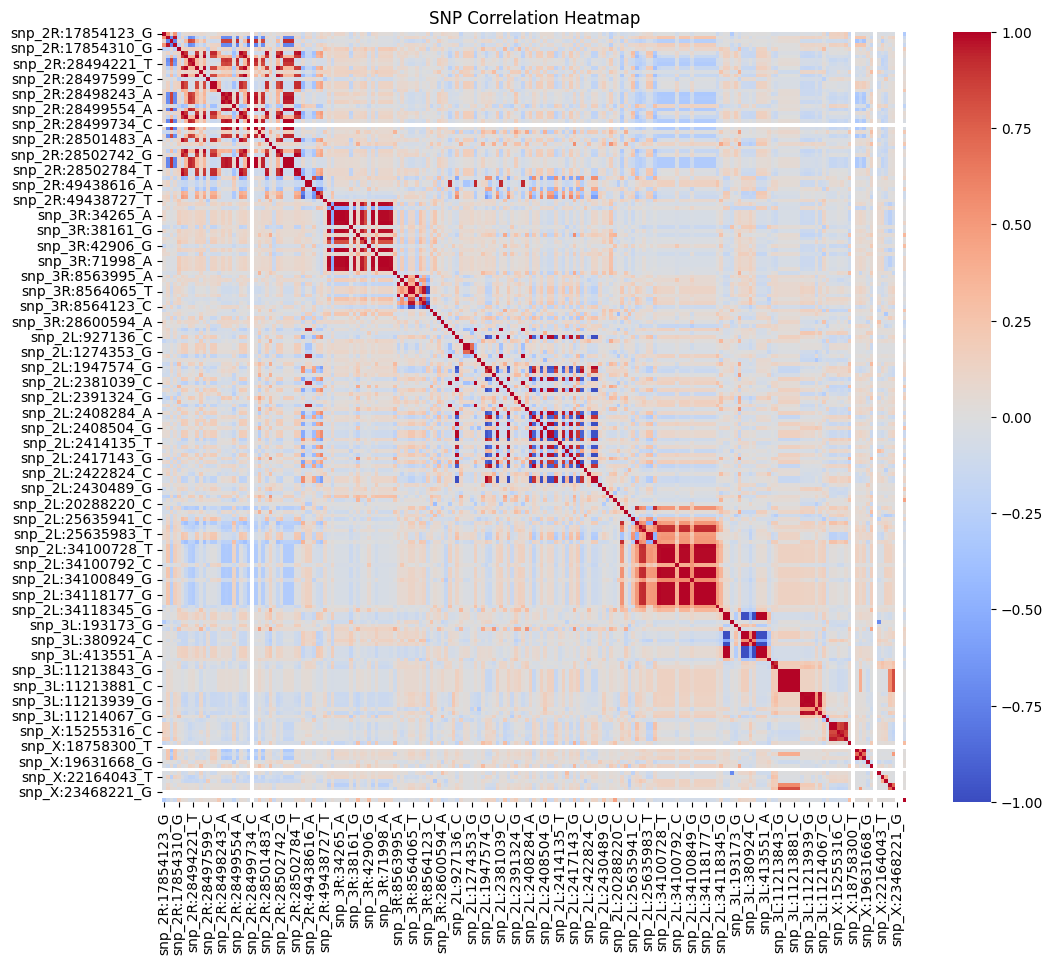

Total SNPs before selection: 203
SNPs removed due to positive correlation: 106
SNPs removed due to negative correlation: 20
Total SNPs removed: 126
SNPs retained after selection: 77


In [10]:
selected_snps = {}
for method in methods:
    selected_snps[method] = linked(df_genos[method].filter(like='snp_').dropna().astype(int), df_effs[method])

## Calculating PGS

*PGS = Σ(βi * Xi)*

Where:
- PGS is the Polygenic Score
- Σ represents the sum over all considered SNPs
- βi is the effect size (log odds) of the i-th SNP
- Xi is the number of risk alleles (0, 1, or 2) for the i-th SNP in an individual

In [59]:
def calculate_pgs(df_snp, df_eff, df_amp_samples, sig_only=False, standardize=True):
    assert df_snp.columns.is_unique, "SNP genotype columns must be unique."
    assert df_eff.index.is_unique, "Effect size index must be unique."

    missing_effect_snps = set(df_snp.columns) - set(df_eff.index)
    assert not missing_effect_snps, (
        "Some genotype SNPs are missing effect sizes. "
        f"Example SNPs: {list(sorted(missing_effect_snps))[:5]}"
    )

    # align and reorder effects to match genotype columns exactly
    df_eff = df_eff.loc[df_snp.columns]

    df_snp = df_snp.apply(lambda x: x.fillna(x.median()), axis=0)

    if sig_only:
        selected_snps = df_eff.query("sig == True").index.tolist()
        assert len(selected_snps) > 0, "No significant SNPs found with sig_only=True."
        df_snp = df_snp[selected_snps]
        df_eff = df_eff.loc[selected_snps]

    assert np.isfinite(df_eff.odds_ratio).all(), "Found non-finite odds ratios."
    assert (df_eff.odds_ratio > 0).all(), "Odds ratios must be strictly positive to compute log(OR)."

    PRS = _calculate_pgs(genotypes=df_snp.T.values,
                        odds_ratios=df_eff.odds_ratio,
                        standardize=standardize)

    pgs_df = pd.DataFrame({'sample_id': df_snp.T.columns,
                           'prs': PRS})
    pgs_df = pgs_df.merge(df_amp_samples)

    return pgs_df


def _calculate_pgs(genotypes, odds_ratios, standardize=False):
    """
    genotypes: 2D array (n_snps, n_samples) of alt-allele counts (0,1,2)
    odds_ratios: 1D array (n_snps,)
    """
    odds_ratios = np.asarray(odds_ratios).flatten()
    betas = np.log(odds_ratios) # (n_snps,)
    pgs = (genotypes * betas[:, None]).sum(axis=0) # (n_samples,)

    if standardize:  
        pgs = (pgs - pgs.mean()) / pgs.std(ddof=0)  

    return pgs

### PGS scores for genotyped LLINEUP data

We have many samples which were genotyped at ~5 loci using conventional qPCR assays. There is more samples than were whole genome sequenced. 

In [60]:
df_ento = pd.read_csv("./llineup_ento.csv").query("MolSpecies == 'S'").reset_index(drop=True)
df_geno = df_ento[['kdr', 'Cyp4J5', 'Coeaed1', 'Cyp6P4']]

df_geno = df_geno.assign(kdr_f=lambda x: x.kdr,
               kdr_s=lambda x: x.kdr).drop(columns='kdr')

def genotype_to_numeric_resistant(genotype, resistant_allele):
    """
    Encode alleles as 1 if they are the resistant allele, 0 otherwise.
    Returns shape (2,) with np.nan if missing.
    """
    if pd.isna(genotype):
        return np.array([np.nan, np.nan], dtype=float)

    # Normalize possible genotype formats
    # - tuple/list like ('F','S')
    # - string like "FS" or "F/S"
    if isinstance(genotype, str):
        gt = genotype.replace("/", "").replace("|", "").strip()
        alleles = list(gt)
    else:
        alleles = list(genotype)

    if len(alleles) != 2:
        # Fallback: pad/truncate to diploid expectation
        alleles = (alleles + [np.nan, np.nan])[:2]

    return np.array([int(allele == resistant_allele) if not pd.isna(allele) else np.nan
                     for allele in alleles], dtype=float)

def convert_genotypes_to_3d_array(df, snp_columns, resistant_alleles):
    n_snps = len(snp_columns)
    n_samples = df.shape[0]
    n_ploidy = 2  # diploid
    genotype_array = np.zeros((n_snps, n_samples, n_ploidy), dtype=float)

    for i, (column, r_allele) in enumerate(zip(snp_columns, resistant_alleles)):
        genotype_array[i] = np.array(
            [genotype_to_numeric_resistant(gt, r_allele) for gt in df[column]],
            dtype=float
        )

    return genotype_array

column_letter_pairs = [
    ('Cyp4J5', 'F', '2L:25635973_A'),
    ('Cyp6P4', 'M', '2R:28497967_C'),
    ('kdr_f', 'F', '2L:2422652_T'),
    ('kdr_s', 'S', '2L:2422651_C')
]

snp_columns = [pair[0] for pair in column_letter_pairs]
resistant_alleles = [pair[1] for pair in column_letter_pairs]
snp_positions = [pair[2] for pair in column_letter_pairs]

gn = convert_genotypes_to_3d_array(df_geno, snp_columns, resistant_alleles)

# If you have missing data, don't cast straight to int (NaN -> error).
# Either impute first, or keep as float until later.
gn = allel.GenotypeArray(gn.astype(np.int8))  # only safe if no NaNs remain
gn = allel.GenotypeArray(gn.astype(int))

/tmp/ipykernel_40984/2999718512.py:60: RuntimeWarning:

invalid value encountered in cast



In [61]:
snp_columns

['Cyp4J5', 'Cyp6P4', 'kdr_f', 'kdr_s']

In [62]:
snpsnp_positions = ["snp_" + s for s in snp_positions]
snpsnp_positions

['snp_2L:25635973_A',
 'snp_2R:28497967_C',
 'snp_2L:2422652_T',
 'snp_2L:2422651_C']

In [63]:
df_geno

,Cyp4J5,Coeaed1,Cyp6P4,kdr_f,kdr_s
0,LL,SS,MM,SS,SS
1,FF,SR,MM,SS,SS
2,LF,SR,MM,SS,SS
3,FF,SS,MM,SS,SS
4,FF,SR,MM,SS,SS
...,...,...,...,...,...
3169,LF,SR,MM,FS,FS
3170,LL,SR,MM,FS,FS
3171,LF,SS,MM,FS,FS
3172,LL,SR,IM,FS,FS


In [64]:
pval_df = pd.read_csv("./effect-sizes-siaya.csv", index_col=1)

# pval_df = df_effs['amplicons']
pval_genotyped_df = pval_df.loc[snpsnp_positions]
#pval_genotyped_df.to_excel("pval_genotyped_df.xlsx")

In [65]:
def llineup_prs(df_ento, gn, query=None, name='prs_standardised', standardize=False):
    if query:
        mask = df_ento.eval(query, engine='python')
        gn = gn.compress(mask, axis=1)
        df_ento = df_ento[mask]

    prs  = _calculate_pgs(gn.to_n_alt(), pval_genotyped_df['odds_ratio'].values, standardize=standardize)
    df_ento.loc[:, 'prs'] = prs
    prs_per_hsd = df_ento.groupby('HSD').agg({'prs':['mean', 'std', 'count']})

    return df_ento,  prs_per_hsd

In [66]:
df_ento_prs, prs_per_hsd = llineup_prs(df_ento, gn, query=None, name='prs', standardize=False)

df_ento_prs_norm, prs_norm_per_hsd = llineup_prs(df_ento, gn, query=None, name='prs', standardize=True)

In [67]:
px.histogram(prs_per_hsd['prs']['mean'],  template='simple_white',  width=500, height=300)

### Write out RND 1 and east samples to .csv 

We are restricting analysis to baseline and eastern samples.

In [68]:
df_ento_prs.to_csv("df_ento_prs.csv", index=False)

In [69]:
df_ento_prs.sort_values('prs', ascending=False).head(10)[['kdr', 'Cyp4J5', 'Cyp6P4', 'prs']]

,kdr,Cyp4J5,Cyp6P4,prs
3034,FF,FF,MM,3.087909
3044,FF,FF,MM,3.087909
2996,FF,FF,MM,3.087909
3053,FF,FF,MM,3.087909
3063,FF,FF,MM,3.087909
3003,FF,FF,MM,3.087909
1078,FF,FF,MM,3.087909
3047,FF,FF,MM,3.087909
2063,FF,FF,MM,3.087909
2862,FF,FF,MM,3.087909
